0. Prerequisites

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
import nltk
from transformers import pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

1. Data Cleaning & Preprocessing

In [4]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Read the text file
with open('Lord_of_The_Rings.txt', 'r', encoding='utf-8', errors='ignore') as file:
    text = file.read()

# Identify books and chapters using regular expressions
books = re.split(r'BOOK [IVXLCDM]+', text)
books = [book.strip() for book in books if book.strip()]

structured_data = []
for book_num, book in enumerate(books, start=1):
    chapters = re.split(r'Chapter \d+', book)
    chapters = [chapter.strip() for chapter in chapters if chapter.strip()]
    # Debugging: Print the chapters list to see if there are any extra empty strings
    # print(f"Book {book_num} chapters:", chapters)
    for chapter_num, chapter in enumerate(chapters, start=0):
        structured_data.append((f'BOOK {book_num}', f'Chapter {chapter_num}', chapter))

# Create a DataFrame with structured data
df = pd.DataFrame(structured_data, columns=['Book', 'Chapter', 'Text'])

# NLTK stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

# Apply the cleaning function to the text in the DataFrame
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Explode the cleaned text into individual words
exploded_df = df.explode('Cleaned_Text')

# Rename the exploded column for clarity
exploded_df = exploded_df.rename(columns={'Cleaned_Text': 'Word'})

# Select relevant columns
final_df = exploded_df[['Book', 'Chapter', 'Word']]

# Remove NaN values
final_df = final_df.dropna()

# Reset the index
final_df = final_df.reset_index(drop=True)

# Save to a CSV file (optional)
final_df.to_csv('Lord_of_the_Rings_Words.csv', index=False)

# Display the final DataFrame
print(final_df.head())


[nltk_data] Downloading package punkt to /home/fericf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fericf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fericf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     Book    Chapter     Word
0  BOOK 1  Chapter 1    party
1  BOOK 1  Chapter 1    bilbo
2  BOOK 1  Chapter 1  baggins
3  BOOK 1  Chapter 1      bag
4  BOOK 1  Chapter 1      end


2. Sentiment Analysis

2.1 VADER Model

In [5]:
# Download necessary NLTK data
nltk.download('vader_lexicon')

# Sentiment analysis setup
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

# Assuming `df` is your DataFrame with the structured data

# Apply sentiment analysis to each chapter
df['Sentiment'] = df['Text'].apply(get_sentiment)

# Calculate overall sentiment
overall_sentiment = sid.polarity_scores(' '.join(df['Text']))['compound']

# Save sentiment data to a CSV file (optional)
df[['Book', 'Chapter', 'Sentiment']].to_csv('Lord_of_the_Rings_Sentiment.csv', index=False)

# Print the sentiment for each chapter
print(df[['Book', 'Chapter', 'Sentiment']].head(10))

# Print the overall sentiment of the text
print(f"Overall Sentiment of the Text: {overall_sentiment}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     Book    Chapter  Sentiment
0  BOOK 1  Chapter 0     0.0000
1  BOOK 1  Chapter 1     1.0000
2  BOOK 1  Chapter 2     0.9999
3  BOOK 1  Chapter 3     0.9999
4  BOOK 1  Chapter 4     0.9983
5  BOOK 1  Chapter 5     0.9999
6  BOOK 1  Chapter 6     0.9991
7  BOOK 1  Chapter 7     0.9999
8  BOOK 1  Chapter 8     0.9998
9  BOOK 1  Chapter 9     0.9997
Overall Sentiment of the Text: 1.0


2.2 Transformer from Huggin Face

In [6]:
# Sentiment analysis setup using Hugging Face's transformers pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

def get_sentiment(text):
    # Split text into chunks of max 512 tokens
    max_length = 256
    tokens = text.split()
    chunks = [' '.join(tokens[i:i + max_length]) for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in chunks:
        result = sentiment_pipeline(chunk)[0]
        sentiments.append(1 if result['label'] == 'POSITIVE' else -1)
    
    # Return the average sentiment of the chunks
    return np.mean(sentiments)

# Assume df is your DataFrame with columns 'Book', 'Chapter', and 'Text'
# Apply sentiment analysis to each chapter
df['Sentiment'] = df['Text'].apply(get_sentiment)

# Calculate overall sentiment
overall_sentiment = get_sentiment(' '.join(df['Text']))

# Save sentiment data to a CSV file (optional)
df[['Book', 'Chapter', 'Sentiment']].to_csv('Lord_of_the_Rings_Sentiment.csv', index=False)

# Print the sentiment for each chapter
print(df[['Book', 'Chapter', 'Sentiment']].head())

# Print the overall sentiment of the text
print(f"Overall Sentiment of the Text: {overall_sentiment}")

# Convert sentiment values to numeric values
df['sentiment_value'] = df['Sentiment']

# Extract numeric part of 'Chapter' and convert to integers for sorting
df['Chapter'] = df['Chapter'].str.extract('(\d+)').astype(int)

# Filter out chapters labeled as 0 and sort by chapters
df = df[df['Chapter'] != 0]
df = df.sort_values(by='Chapter')

# Calculate the average sentiment per chapter
avg_sentiment_per_chapter = df.groupby(['Book', 'Chapter'])['sentiment_value'].mean().reset_index()

# Calculate the average sentiment per book
avg_sentiment_per_book = df.groupby('Book')['sentiment_value'].mean().reset_index()

/home/fericf/Documents/University/Data Mining/Python Scripts/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/fericf/Documents/University/Data Mining/Python Scripts/.conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, a

     Book    Chapter  Sentiment
0  BOOK 1  Chapter 0   1.000000
1  BOOK 1  Chapter 1  -0.128205
2  BOOK 1  Chapter 2  -0.363636
3  BOOK 1  Chapter 3  -0.631579
4  BOOK 1  Chapter 4  -0.391304
Overall Sentiment of the Text: -0.3770491803278688


2.3 Creating the visualization of the data

In [7]:
# Create the subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Average Sentiment per Chapter", "Average Sentiment per Book", "Overall Sentiment"),
    vertical_spacing=0.1,
    specs=[[{"type": "xy"}], [{"type": "xy"}], [{"type": "domain"}]]
)

# Subplot 1: Sentiment per chapter for each book
for book in df['Book'].unique():
    book_data = avg_sentiment_per_chapter[avg_sentiment_per_chapter['Book'] == book]
    fig.add_trace(
        go.Scatter(x=book_data['Chapter'], y=book_data['sentiment_value'], mode='lines+markers', name=f'{book} Sentiment per Chapter'),
        row=1, col=1
    )

# Subplot 2: Average sentiment per book
fig.add_trace(
    go.Bar(x=avg_sentiment_per_book['Book'], y=avg_sentiment_per_book['sentiment_value'], name='Average Sentiment per Book'),
    row=2, col=1
)

# Subplot 3: Overall mean sentiment
fig.add_trace(
    go.Indicator(
        mode="number",
        value=overall_sentiment,
        title={"text": "The overall sentiment of the series is:"}
    ),
    row=3, col=1
)

# Update layout to show all chapter numbers on the x-axis
fig.update_xaxes(dtick=1, row=1, col=1)
fig.update_layout(height=800, title_text="Sentiment Analysis of Lord of the Rings")
fig.show()

3.0 N-Grams and their occurances

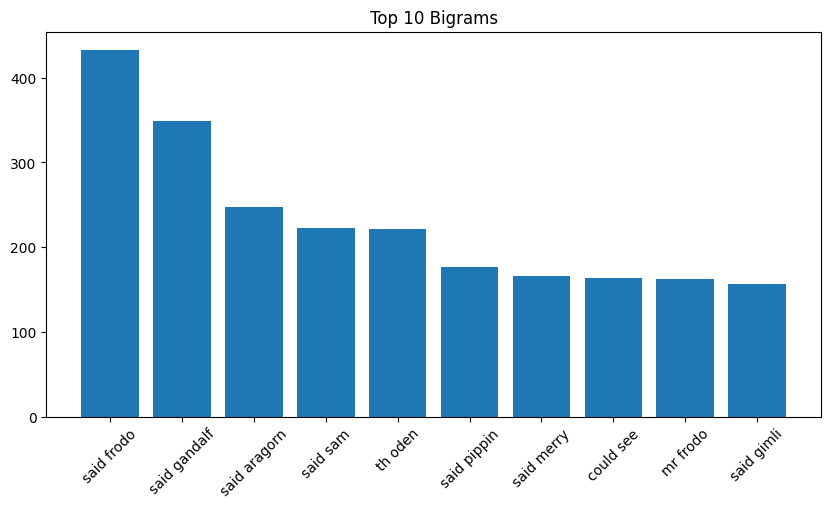

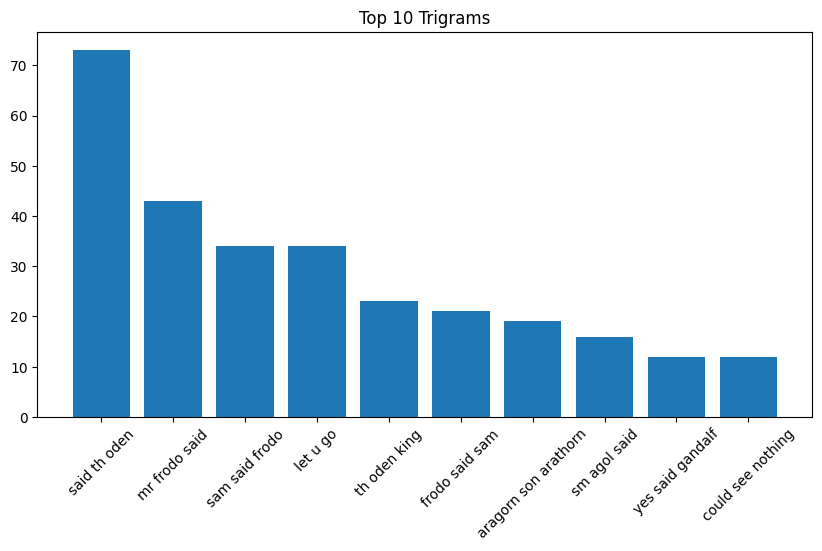

Top 10 Bigrams: [('said frodo', 433), ('said gandalf', 349), ('said aragorn', 247), ('said sam', 223), ('th oden', 222), ('said pippin', 176), ('said merry', 166), ('could see', 163), ('mr frodo', 162), ('said gimli', 157)]
Top 10 Trigrams: [('said th oden', 73), ('mr frodo said', 43), ('sam said frodo', 34), ('let u go', 34), ('th oden king', 23), ('frodo said sam', 21), ('aragorn son arathorn', 19), ('sm agol said', 16), ('yes said gandalf', 12), ('could see nothing', 12)]


In [8]:
# Preprocess text data
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['Processed_Text'] = df['Text'].apply(preprocess)

# 1. TF-IDF Implementation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# 3. N-grams
def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Generate bigrams and trigrams
df['Bigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 2))
df['Trigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 3))

# Analyze the most common n-grams
bigrams = Counter([bigram for sublist in df['Bigrams'] for bigram in sublist])
trigrams = Counter([trigram for sublist in df['Trigrams'] for trigram in sublist])

# Plot the most common bigrams and trigrams
def plot_ngrams(ngrams_counter, title):
    common_ngrams = ngrams_counter.most_common(10)
    ngrams, counts = zip(*common_ngrams)
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_ngrams(bigrams, 'Top 10 Bigrams')
plot_ngrams(trigrams, 'Top 10 Trigrams')

# Insights
print("Top 10 Bigrams:", bigrams.most_common(10))
print("Top 10 Trigrams:", trigrams.most_common(10))

4.0 Calculate the word frequency and extract the top 50 words

In [10]:
# Calculate word frequencies
word_freq = Counter(final_df['Word'])

# Select top 50 words (adjust the number as needed)
top_words = word_freq.most_common(50)
top_words = dict(top_words)  # Convert to dictionary for wordcloud input

4.1 Wordcloud with the most common words

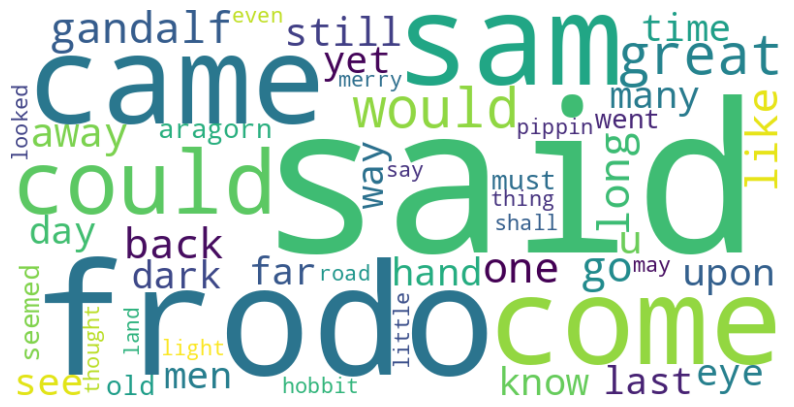

In [11]:
# Generate wordcloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

# Plot the wordcloud
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

4.2 Wordcloud made of Gollum

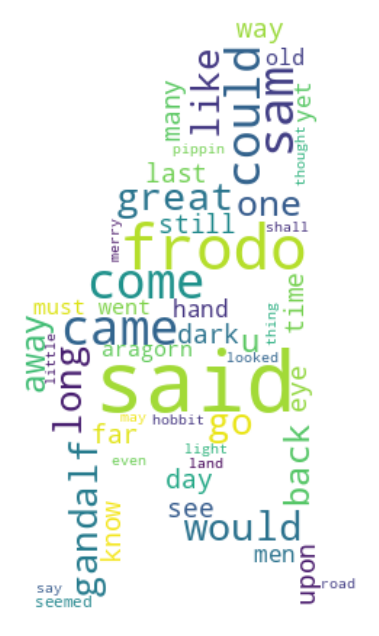

In [12]:
# Load the mask image
mask = np.array(Image.open('Gollum_Render.png'))  # Replace with your image file

# Generate wordcloud with mask
wc_masked = WordCloud(width=800, height=400, background_color='white', mask=mask).generate_from_frequencies(top_words)

# Plot the wordcloud with mask
plt.figure(figsize=(10, 8))
plt.imshow(wc_masked, interpolation='bilinear')
plt.axis('off')
plt.show()


        5.0 Part of Speech recogniziton

5.1 Creating the PoS DataFrame

In [18]:
# Ensure the required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Tokenize the text
tokens = nltk.word_tokenize(df['Text'].str.cat(sep=' '))

# Perform PoS tagging
pos_tags = nltk.pos_tag(tokens, tagset='universal')

# Convert PoS tags to a DataFrame
final_df_pos = pd.DataFrame(pos_tags, columns=['Word', 'PoS'])
display(final_df_pos)

[nltk_data] Downloading package punkt to /home/fericf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


,Word,PoS
0,_,VERB
1,A,DET
2,Long-expected,NOUN
3,Party,NOUN
4,When,ADV
...,...,...
555813,and,CONJ
555814,saw,VERB
555815,no,DET
555816,more,ADV


5.2 Advanced Plotting Using Seaborn

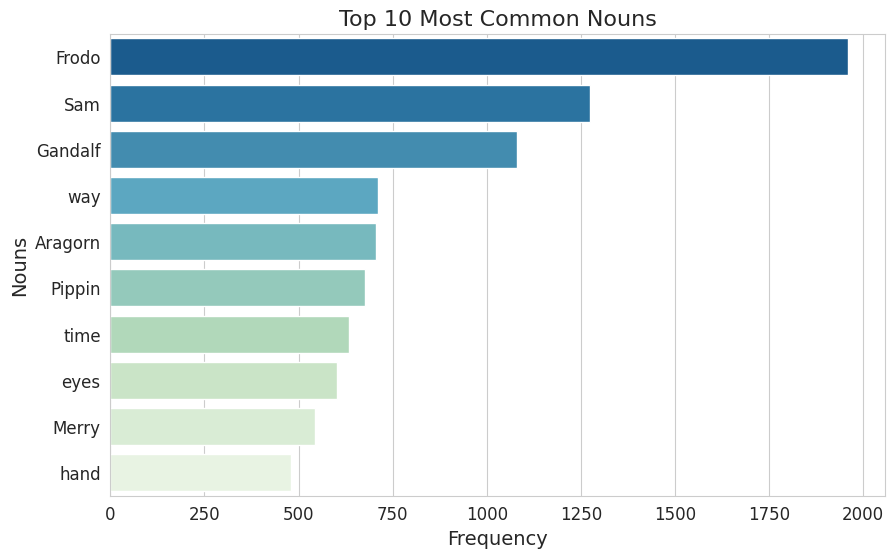

In [25]:
# Filter DataFrame for rows where PoS is 'NOUN'
nouns_df = final_df_pos[final_df_pos['PoS'] == 'NOUN']

# Count the occurrences of each noun, find top 10
noun_counts = nouns_df['Word'].value_counts()
top_10_nouns = noun_counts.head(10)

# Convert the Series to DataFrame for seaborn
top_10_nouns_df = top_10_nouns.reset_index()
top_10_nouns_df.columns = ['Nouns', 'Frequency']

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Nouns', data=top_10_nouns_df, palette="GnBu_r", hue='Nouns')

# Add titles and labels
plt.title('Top 10 Most Common Nouns', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Nouns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


5.3 Multi-PoS Plot

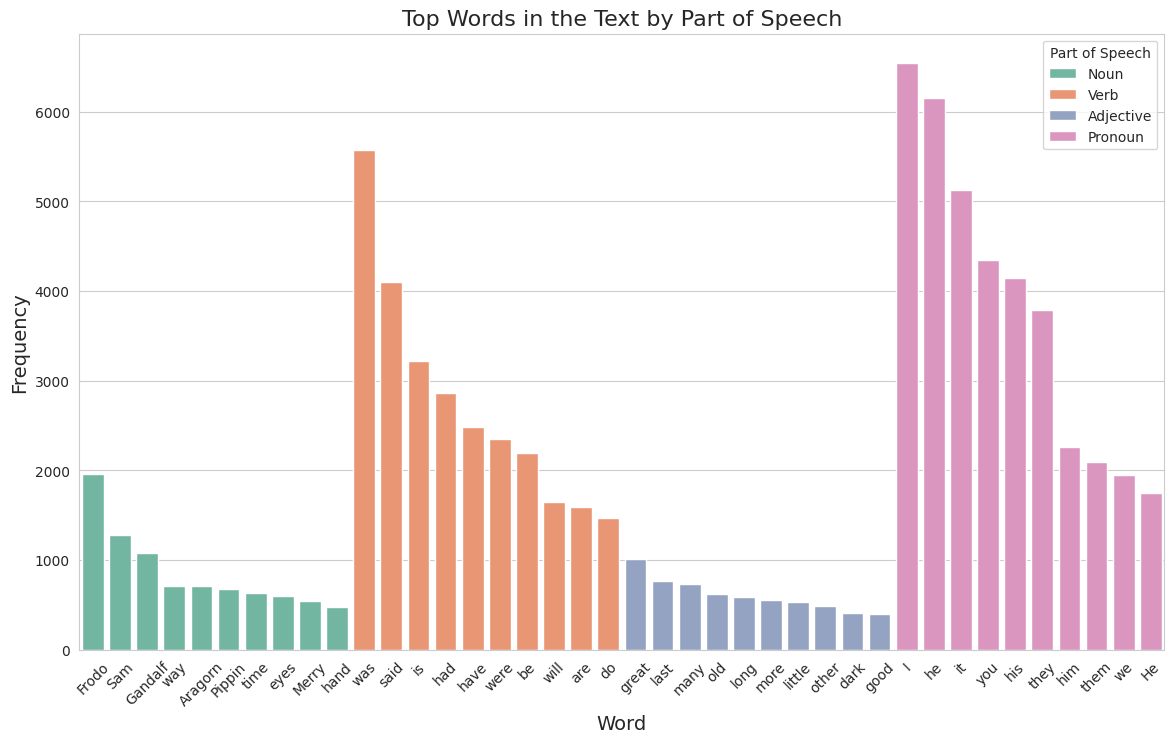

In [22]:
# Count occurrences of each PoS and find top 10
noun_counts = final_df_pos[final_df_pos['PoS'] == 'NOUN']['Word'].value_counts().head(10)
verb_counts = final_df_pos[final_df_pos['PoS'] == 'VERB']['Word'].value_counts().head(10)
adj_counts = final_df_pos[final_df_pos['PoS'] == 'ADJ']['Word'].value_counts().head(10)
pronoun_counts = final_df_pos[final_df_pos['PoS'] == 'PRON']['Word'].value_counts().head(10)

# Combine the top words into a single DataFrame
top_words_combined = pd.concat([
    noun_counts.rename('Frequency').reset_index().assign(PoS='Noun'),
    verb_counts.rename('Frequency').reset_index().assign(PoS='Verb'),
    adj_counts.rename('Frequency').reset_index().assign(PoS='Adjective'),
    pronoun_counts.rename('Frequency').reset_index().assign(PoS='Pronoun')
])

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Word', y='Frequency', hue='PoS', data=top_words_combined, palette='Set2')
plt.title('Top Words in the Text by Part of Speech', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Part of Speech')
plt.show()


5.4 Frequency-Sorted Multi-PoS Plot


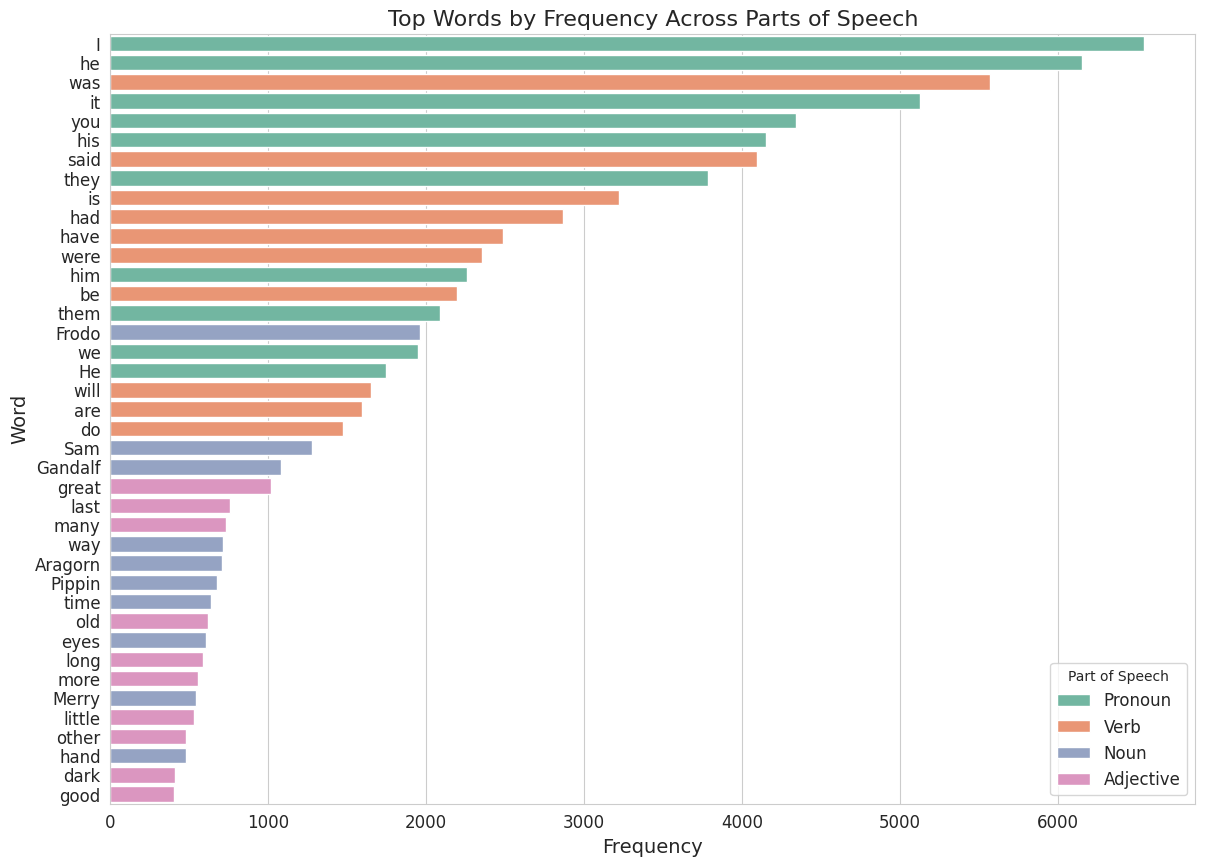

In [23]:
# Sort the DataFrame by 'Frequency' in descending order
top_words_sorted = top_words_combined.sort_values(by='Frequency', ascending=False)

# Plot with sorted values
plt.figure(figsize=(14, 10))
sns.barplot(y='Word', x='Frequency', hue='PoS', data=top_words_sorted, palette='Set2', dodge=False)
plt.title('Top Words by Frequency Across Parts of Speech', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Part of Speech', fontsize=12)
plt.show()